# Use case 3: retrieving footprints

## Notebook setup

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import s1etad
from s1etad import Sentinel1Etad, ECorrectionType

## Open the dataset

In [5]:
filename = '../../sample-products/S1B_IW_ETA__AXDV_20190805T162509_20190805T162536_017453_020D3A_____.SAFE'

In [6]:
eta = Sentinel1Etad(filename)

In [7]:
eta

Sentinel1Etad("../../sample-products/S1B_IW_ETA__AXDV_20190805T162509_20190805T162536_017453_020D3A_____.SAFE")  # 0x7f8b60575710
Sentinel-1 products list:
  S1B_IW_SLC__1ADV_20190805T162509_20190805T162536_017453_020D3A_A857.SAFE
Number of swaths: 3
Swath list: IW1, IW2, IW3
Grid sampling:
  x: 8.081406101630269e-07
  y: 0.028777788199999974
  unit: s
Grid spacing:
  x: 200.0
  y: 200.0
  unit: m
Processing settings:
  troposphericDelayCorrection: True
  ionosphericDelayCorrection: True
  solidEarthTideCorrection: True
  bistaticAzimuthCorrection: True
  dopplerShiftRangeCorrection: True
  FMMismatchAzimuthCorrection: True

## Helpers

In [8]:
import cartopy.crs as ccrs
from matplotlib import patches as mpatches
from shapely.geometry import MultiPolygon

def tile_extent(poly, margin=2):
    bounding_box = list(poly.bounds)
    bounding_box [1:3] = bounding_box [2:0:-1]
    return np.asarray(bounding_box ) + [-margin, margin, -margin, margin]

## Get footpitints of the selected bursts

In [9]:
polys = eta.get_footprint(selection=['IW1', 'IW2', 'IW3'])

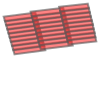

In [10]:
polys

## Plot footprints

/Users/valentino/anaconda3/envs/p37/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: The StamenTerrain class was deprecated in v0.17. Please use Stamen('terrain-background') instead.
  from ipykernel import kernelapp as app


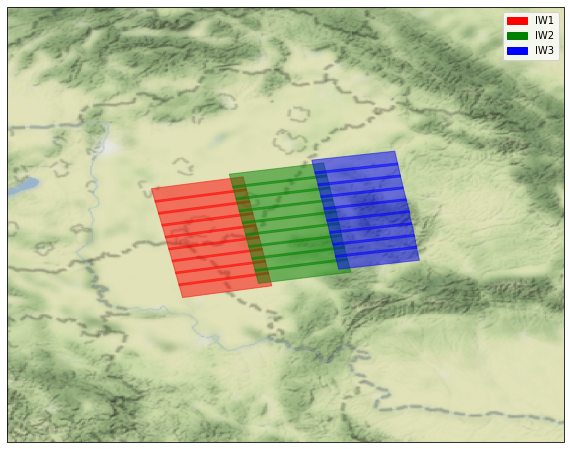

In [11]:
fig = plt.figure(figsize=[10, 8])
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent(tile_extent(MultiPolygon(polys)))

# Put a background image on for nice sea rendering.
OFFLINE = False
if OFFLINE:
    import cartopy.feature as cfeature
    ax.stock_img()
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
else:
    import cartopy.io.img_tiles as cimgt
    # stamen_terrain = cimgt.Stamen('terrain-background')  # need cartopy >= 0.18
    stamen_terrain = cimgt.StamenTerrain()
    ax.add_image(stamen_terrain, 6)  # up to 10
    ax.coastlines()

# plot footprints of all selected burst
# ax.add_geometries(polys, crs=ccrs.PlateCarree(), alpha=0.8)

# get the footprints of each swath and plot them with different colors
items = []
for swath, color in zip(eta, ['red', 'green', 'blue']):
    polys = swath.get_footprint()
    item = ax.add_geometries(polys, crs=ccrs.PlateCarree(), alpha=0.5,
                             color=color)
    items.append(item)

handles = [
    mpatches.Patch(color=color, label=label)
    for color, label in zip(['red', 'green', 'blue'], eta.swath_list)
]
plt.legend(handles=handles)